# Логистичка регресија
## Предвидување на преживеани во Titanic податочното множество

Податоците за преживеаните патници од бродот Titanic ќе ги искористиме за да изградиме модел кој ќе предвидува кој има поголема веројатност да преживее.

Податочното множество ги содржи следните колони:

* **PassengerId:** Идентификациски број на патникот
* **Pclass:** Патничка класа
* **Name:** Име на патникот
* **Sex:** Пол на патникот
* **Age:** Возраст на патникот
* **SibSp:** Број на браќа-сестри/брачен другар кои што се со патникот на бродот
* **Parch:** Број на родители/деца кои што се со патникот на бродот
* **Ticket:** Број на билетот
* **fare:** Цена на билетот
* **Cabin:** Број на кабина во која бил сместен патникот
* **Embarked:** Пристаниште каде се качил патникот
* **Survival:** Дали преживеал патникот

Дополнителни податоци:
Pclass: Алтернатива за социо-економската состојба на патникот
1st = Прва класа
2nd = Средна класа
3rd = Ниска класа

age: Возраста може да биде и рацинален број за патници помали од 1 година

sibsp: Роднинските врска можат да бидат претставени на следниот начин...
Sibling = брат, сестра, полубрат, полусестра
Spouse = Сопруг, сопруга (верениците се игнорирани)

parch: Роднинските врска можат да бидат претставени на следниот начин
Parent = мајка, татко
Child = ќерка, син, полусин, полуќерка
Некои деца патувале само со дадилка, последователно parch=0 за нив.

## Користени библиотеки

In [450]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

## Вчитување на податоците

In [161]:
data = pd.read_csv('titanic_train.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [184]:
data = pd.read_csv('titanic_train.csv', 
                   dtype={'Pclass': 'uint8', 'Age': 'float16', 'SibSp': 'uint8', 'Parch': 'uint8', 'Survived': 'bool'}, 
                   usecols=range(1, 12))

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null uint8
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float16
SibSp       891 non-null uint8
Parch       891 non-null uint8
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float16(1), float64(1), int64(1), object(5), uint8(3)
memory usage: 53.2+ KB


In [32]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.687500,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.523438,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.419922,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Истражување и визуелизација на податоците

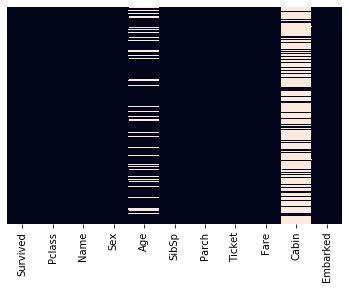

In [38]:
sns.heatmap(data.isna(), cbar=False, yticklabels=False)

Множеството содржи многу редици кај кои недостасува вредност во колоната за Кабина и Возраст. Понатамошно ќе треба да се искористи оваа информација за да се одлучи што ќе се прави со овие вредности кои недостасуваат.

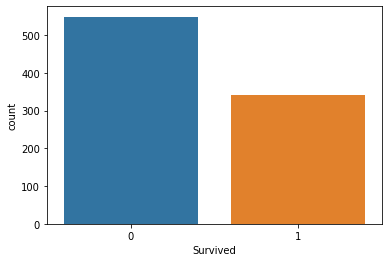

In [40]:
sns.countplot(x='Survived', data=data)

Од множеството може да се види дека излезната величина е нерамномерно распределена по однос на преживеани и ова мора да се земе предвид при начинот на евалуација на моделот.

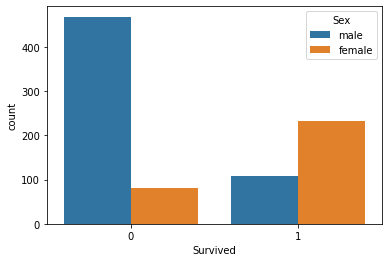

In [43]:
sns.countplot(x='Survived', data=data, hue='Sex')

Од дијаграмот може да се заклучи дека значително повеќе преживеале жени од мажи, и најверојатно карактеристиката за полот ќе биде добра за да се искористи при предвидување. Овој заклучок е валиден само под услов доколку на бродот немало повеќе жени од мажи што се докажува со графикот подоле.

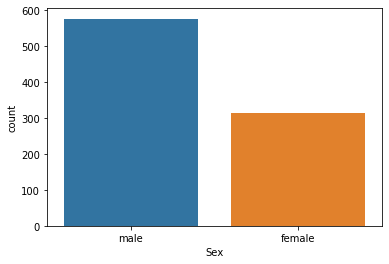

In [45]:
sns.countplot(x='Sex', data=data)

Дали можеби и патничката класа би можела да биде добра карактеристика за предвидување на преживеаните.

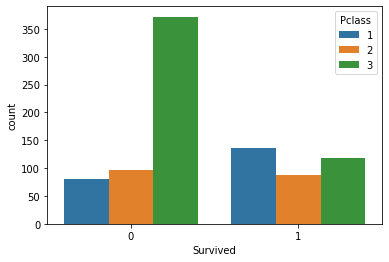

In [47]:
sns.countplot(x='Survived', data=data, hue='Pclass')

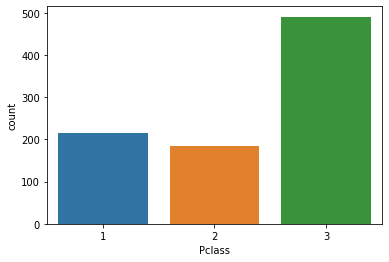

In [49]:
sns.countplot(x='Pclass', data=data)

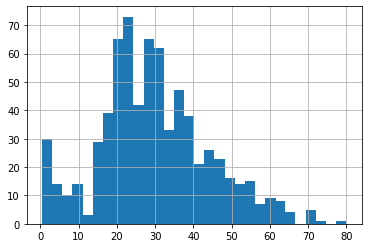

In [53]:
data['Age'].hist(bins=30)

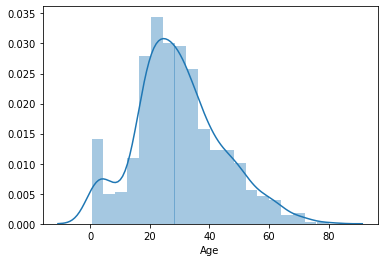

In [57]:
sns.distplot(data['Age'].dropna())

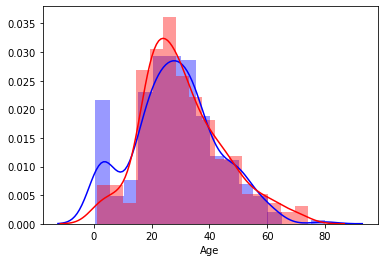

In [92]:
sns.distplot(data.loc[data['Survived'] == 1, 'Age'].dropna(), color='b')
sns.distplot(data.loc[data['Survived'] == 0, 'Age'].dropna(), color='r')

Со оглед на тоа дека значителен број на патниците се деца, може да се додаде дополнителна карактеристика која ќе означува дали патникот е дете или возрасен.

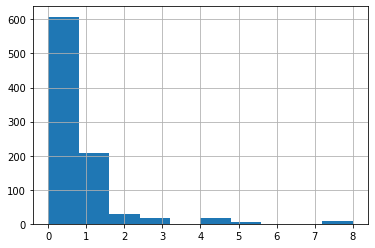

In [59]:
data['SibSp'].hist()

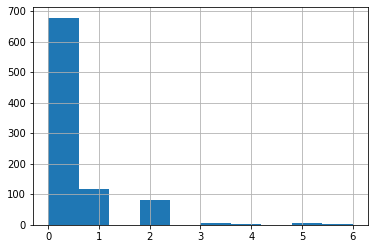

In [61]:
data['Parch'].hist()

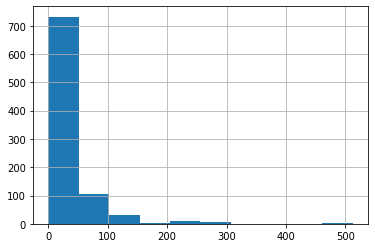

In [62]:
data['Fare'].hist()

Студентот може како вежба да види дали има зависност помеѓу преживеаните и оние кои купиле поскапи билети, имаат деца, се на пониска возраст итн. Доколку навистина постои зависност тогаш може да се додаде дополнителна карактеристика во множеството. Истражете ја функцијата **FacetGrid** од библиотеката Seaborn.

## Прочистување на податоците

Постојат два начина за да се справиме со податоците кои недостасуваат:
1. **Елиминација на сите редици каде недостасуваат податоци**

    Се применува само кога вредностите кои недостасуваат се многу малку на број, односно кога елиминацијата на редици нема да значително до го намали множеството
2. **Елиминација на цела колона**

    Се применува кога една колона од табелата има големо количество од податоците кои недостасуваат. Во овој случај поисплатливо е да се елиминира цела колона отколку сите редици каде недостасуваат податоци во таа колона.

3. **Пополнување на податоците кои недостасуваат** - (Data Imputation)

    Податоците кои недостасуваат се пополниуваат со помош на информација од постоечките податоци во табелата. Новопополнетите податоци веројатно нема да бидат исти како вистинските, но ќе претставуваат приближна вредност. На овој начин се овозможува да се искористи информацијата од редиците(колоните) кои инаку би се избришале и на тој начин се добива можност да се подобри точноста на моделот.
    
### Справување со податоците кои недостасуваат во колоната Embarked

In [185]:
data['Embarked'].isna().sum()

2

In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null uint8
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float16
SibSp       891 non-null uint8
Parch       891 non-null uint8
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float16(1), float64(1), int64(1), object(5), uint8(3)
memory usage: 53.2+ KB


Со оглед на тоа што се работи за само две редици можеме да ја примениме метода 1 така што ќе ги елиминираме.

In [187]:
data.dropna(axis=0, subset=['Embarked'],  inplace=True)

In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
Survived    889 non-null int64
Pclass      889 non-null uint8
Name        889 non-null object
Sex         889 non-null object
Age         712 non-null float16
SibSp       889 non-null uint8
Parch       889 non-null uint8
Ticket      889 non-null object
Fare        889 non-null float64
Cabin       202 non-null object
Embarked    889 non-null object
dtypes: float16(1), float64(1), int64(1), object(5), uint8(3)
memory usage: 59.9+ KB


### Справување со податоците кои недостасуваат во колоната Cabin
Секое поле за кабината на патникот е од тип „X1X2“ каде X1 е секторот на бродот, а X2 е бројот на кабината. Податоците за кабината на патникот можат да содржат значајна информација од аспект на тоа дали патникот бил сместен на подолните спратови од бродот или близу палубата. Во идеален случај би можело да се извлече секторот како нова карактеристика каде што недостатокот на кабината како поле за патникот може да значи дека тој воопшто немал резервирано. Ова нека остане како вежба за студентот, а во овој случај ќе ја примениме метода 3 и ќе ја елиминираме цела колона.

In [189]:
data.drop(columns='Cabin', inplace=True)

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null uint8
Name        889 non-null object
Sex         889 non-null object
Age         712 non-null float16
SibSp       889 non-null uint8
Parch       889 non-null uint8
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float16(1), float64(1), int64(1), object(4), uint8(3)
memory usage: 53.0+ KB


### Справување со податоците кои недостасуваат во колоната Age
Со оглед на тоа што за голем број на патници не е позната возраста, би било непрактично доколку се отстранат толку многу редици со вредност Nan. Од друга страна не би било практично да се отстрани колоната за возраст бидејќи таа е значајна карактеристика за предвидување на преживеаните кај патниците со помала возраст(деца). Во овој случај ќе ги пополниме вредностите кои што недостасуваат според информации добиени од постоечките податоци на табелата.

Еден пристап би било да се најде просечната возраст на патниците и таа да се пополни на местото каде што недостасува. Сепак можеме да го подобриме овој пристап така што секаде каде што недостасува возраста ќе пополниме просечна возраст во зависност од вредноста во другите колони(патничка класа, пол, цена на билет итн.)

Ќе ги пресметаме средните возрасти по пол и ќе видиме дали полот влијае на возраста на патникот.

In [191]:
means = data.groupby(['Sex', 'Pclass'])['Age'].mean()
means

Sex     Pclass
female  1         34.250000
        2         28.718750
        3         21.750000
male    1         41.281250
        2         30.734375
        3         26.500000
Name: Age, dtype: float16

Со оглед на тоа што дека има разлика во средните вредности кај секоја од паровите по пол и класа, можеме да ги искористиме овие колони за да ги пополниме вредностите кои недостасуваат. На овој начин би добиле поблиски возрасти до реалните.

In [192]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null uint8
Name        889 non-null object
Sex         889 non-null object
Age         712 non-null float16
SibSp       889 non-null uint8
Parch       889 non-null uint8
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float16(1), float64(1), int64(1), object(4), uint8(3)
memory usage: 53.0+ KB


In [193]:
for sex, pclass in means.index:
    data.loc[data['Age'].isnull() & (data['Sex'] == sex) & (data['Pclass'] == pclass), 'Age'] = means[sex][pclass]

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null uint8
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float16
SibSp       889 non-null uint8
Parch       889 non-null uint8
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float16(1), float64(1), int64(1), object(4), uint8(3)
memory usage: 53.0+ KB


## Справување со категорички карактеристики
Едно податочно множество може да има два типа на карактеристики и секој од овие типови треба да се третираат посебно при процесирање на податоците.

1. **Нумерички карактеристики:**
    
    Уште се нарекуваат квантитативни карактеристики чии податоци се опишуваат со помош на бројна вредност. Типичен пример за овие карактеристики се возраст, маса, висина, број на гласови, број на учесници, итн. Секогаш може да се извршуваат математички операции на овие карактеристики и нивните резултатите би давале логички вредности кои можат да се применат како: средна вредност, медијана, производ/разлика/количник од две или повеќе карактеристики итн.
2. **Категорички карактеристики:** 

    Овие карактеристики уште се нарекуваат квалитативни карактеристики и тие опишуваат припадност на определена категорија. Типичен пример за нив би било пол, бренд на продукт, тип на возило, град, држава, итн. Извршување на математички операции на овој тип на карактеристики би било нелогично и затоа тие не треба да се претставуваат како една карактеристика каде посебна нумеричка вредност се доделува на секоја категорија. Доколку тие се претстават како нумеричка карактеристика тогаш ризикуваме моделот да пронаоѓа математички зависности кои во реалноста тие не постојат. На пр. доколку една карактеристика за бренд на возило е претставена на следниот начин {BWM: 0, Audi: 1, Honda: 2} тогаш ризикуваме моделот да пронајде дека Honda е два пати поголема од Audi. Во такви случаи може да се наруши прецизноста на предвидување на моделот.

    Постојат посебен тип на категорички карактеристики кои уште се нарекуваат ординални карактеристики или подредени. Типичен пример за тоа е патничка класа {Прва класа: 1, Средна класа: 2, Ниска класа: 3}. Иако подреденоста на секоја од патничките класа е евидентна според комфорот и цената на билетот, сепак нивната бројна вредност не значи дека ја опишува истата разлика како реалната разлика на цената и комфорот.

Според горе наведеното увидување, потребно е да се направи трансформација на сите категорички карактеристики како: Pclass, Sex, Embarked.

In [195]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

In [196]:
data['Sex']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 889, dtype: int64

In [197]:
data = pd.concat([data, 
                  pd.get_dummies(data['Pclass'], prefix='Pclass', drop_first=True)], axis=1)

In [198]:
data.drop(columns='Pclass', inplace=True)

In [199]:
data

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Pclass_2,Pclass_3
0,0,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.2500,S,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.2833,C,0,0
2,1,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.9250,S,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.1000,S,0,0
4,0,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.0500,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",0,27.00,0,0,211536,13.0000,S,1,0
887,1,"Graham, Miss. Margaret Edith",1,19.00,0,0,112053,30.0000,S,0,0
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",1,21.75,1,2,W./C. 6607,23.4500,S,0,1
889,1,"Behr, Mr. Karl Howell",0,26.00,0,0,111369,30.0000,C,0,0


In [200]:
data = pd.concat([data, 
                  pd.get_dummies(data['Embarked'], prefix='Embarked', drop_first=True)], axis=1)

In [201]:
data.drop(columns='Embarked', inplace=True)

In [202]:
data

,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,0,"Braund, Mr. Owen Harris",0,22.00,1,0,A/5 21171,7.2500,0,1,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.00,1,0,PC 17599,71.2833,0,0,0,0
2,1,"Heikkinen, Miss. Laina",1,26.00,0,0,STON/O2. 3101282,7.9250,0,1,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.00,1,0,113803,53.1000,0,0,0,1
4,0,"Allen, Mr. William Henry",0,35.00,0,0,373450,8.0500,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,"Montvila, Rev. Juozas",0,27.00,0,0,211536,13.0000,1,0,0,1
887,1,"Graham, Miss. Margaret Edith",1,19.00,0,0,112053,30.0000,0,0,0,1
888,0,"Johnston, Miss. Catherine Helen ""Carrie""",1,21.75,1,2,W./C. 6607,23.4500,0,1,0,1
889,1,"Behr, Mr. Karl Howell",0,26.00,0,0,111369,30.0000,0,0,0,0


Засега нема да ги искористиме колоните како Name и Ticket.

# Градење на модел на логистичка регресија

In [206]:
X = data.drop(columns=['Name', 'Survived', 'Ticket'])
y = data['Survived']

## Поделба на множеството

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state=0)

## Скалирање

In [219]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

## Тренирање и евалуација

In [432]:
model = LogisticRegression(tol=1e-12, C=0.45e-2, fit_intercept=True, max_iter=1000, n_jobs=-1, solver='lbfgs')

In [433]:
model.fit(X_train, y_train)

LogisticRegression(C=0.0045, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-12, verbose=0,
                   warm_start=False)

In [434]:
model.n_iter_

array([10])

In [437]:
model.coef_

array([[ 0.41908878, -0.11608438, -0.04581929,  0.01843314,  0.13866632,
         0.02742106, -0.21701435,  0.03536671, -0.11561116]])

In [435]:
model.score(X_train, y_train)

0.8141891891891891

Евалуација на моделот користејќи го множеството за тестирање. Овој пристап на евалуација не е соодветен бидејќи излезната величина не е рамномерно распределена, односно бројот на непреживеани патници е значително поголем од преживеаните. Поради тоа поприфатливо е да се користи F1_score.

In [440]:
model.score(scaler.transform(X_test), y_test)

0.7811447811447811

In [441]:
y_predicted = model.predict(scaler.transform(X_test))

In [442]:
confusion_matrix(y_predicted, y_test)

array([[168,  56],
       [  9,  64]], dtype=int64)

In [446]:
print(classification_report(y_predicted, y_test))

              precision    recall  f1-score   support

           0       0.95      0.75      0.84       224
           1       0.53      0.88      0.66        73

    accuracy                           0.78       297
   macro avg       0.74      0.81      0.75       297
weighted avg       0.85      0.78      0.79       297



In [455]:
balanced_accuracy_score(y_predicted, y_test)

0.8133561643835616

## Подобрување на моделот преку додавање на дополнителни карактеристики

Во предходниот пример, голем број од колоните беа отфрлени и неискористени за извлекување на дополнителни информации во влезната величина. Овде ќе биде даден предлог за додавање на дополнителни карактеристики со цел да се подобри моделот на предвидување.

1. **Категоризација на возраста:** додавањето на нова карактеристика кој ги категоризира патниците на {деца: Age<12, млади: 12<Age<18, возрасни: 18<Age<35, стари: 35<Age<45, постари: Age>45} може да го подобри предвидувањето така што ќе се овозможи да најде и нелинеарни зависности помеѓу возраста
2. **Титула на патникот:** Од името на патникот може да биде извлечена титула како Sir, Mr, Miss, Mrs, Master, Lady, Countess, Dr, итн. Од оваа титула може да се процени значајноста на патникот како Lady, Sir, Countess, Captain, Colonell, Master, Dr итн. Овие титули можат да се искористат за поделба на патниците според Најзначајни, значајни и незначајни. Титулите Miss и Mrs дополнително може да се искористат како дополнителна карактеристика.
3. **Број на роднини:** бројот на роднини ќе биде SibSp + Parch
4. **Поделба на цената на билетот по лице:** Во множеството постојат патници кои се роднински поврзани и имаат иста цена на билет. Ова укажува дека некои од билетите се групни што значи дека може да се добие нова карактеристика каде цената на билетот ќе се подели по бројот на роднини кај еден патник.
5. **Категоризација на цената на билетот:** исто како во точка 1.
6. **Искористување на Cabin колоната:** иако колоната содржи голем број на редици чии вредности недостасуваат, од неа може да се креира категоричка карактеристика {Нема кабина; Првата буква од Кабината}.
7. **Производ од Fare и Age:**

Пр. за наоѓање на благородниците:

In [474]:
data['Noble'] = data['Name'].str.contains('Sir\.|Countess\.|Lady\.', regex=True)

In [477]:
data['Child'] = data['Name'].str.contains('Master.')

In [479]:
data['Married'] = data['Name'].str.contains('Mrs.')

In [492]:
data['Has_child'] = (data['Sex'] == 1) & (data['Parch'] >= 1) & (data['Age'] > 18)

In [495]:
data['FA_product'] = data['Fare'] * data['Age']

.

.

.

